In [1]:
# analyze data from searches 
import pickle, os
from cryofinder.analyze_search_outputs import incorporate_postfiltered, score_hits, select_best_maps
import torch

emds = [x[:-1].lower().replace('-','_') for x in open("/home/gridsan/jroney/val2025_maps.txt",'r').readlines()]
results = {}
suffix = "_search_res_rot1_trans1_extent0_hartley_slowrotate_postfilternum64_transpf7_numtranspf7_rotpf2.pt"

for i,e in enumerate(emds):
    if os.path.exists('/home/gridsan/jroney/search_results_refac/' + e + suffix):
        res = torch.load('/home/gridsan/jroney/search_results_refac/' + e + suffix, map_location='cpu')

        for k,v in res.items():
            if k in results:
                results[k].append(v)
            else:
                results[k]  = [v]

results = {k: torch.stack(v) if (torch.is_tensor(v[0]) and k not in  ("unique_indices", "corr_pf")) else v for k,v in results.items()}

search_terms = [["doublet", "microtubule"],
                ["complex i"],
                ["apoferritin"],
                ["spike", "sars-cov-2"],
                ["nucleosome"],
                ["fof1", "atp synthase"],
                ["70s"], 
                ["cas9", "spcas9"],
                ["actin"],
                ["hiv;capsid", "hiv;hexamer"],
                ["cdc37", "hsp90"]]

all_topics = sorted(pickle.load(open("/home/gridsan/jroney/emdb_topics.pkl", 'rb')), key=lambda x:x[0])


/tmp/ipykernel_2476402/3177074138.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res = torch.load('/home/gridsan/jroney/search_results_refac/' + e + suffix, map_locati

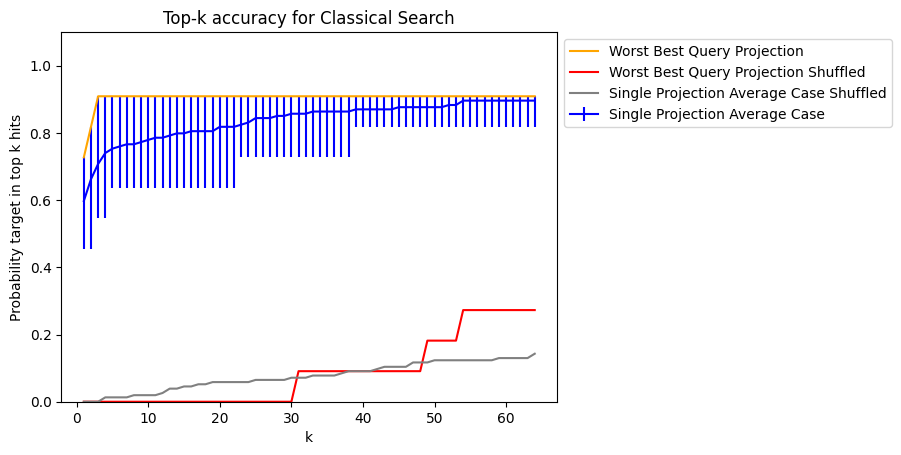

tensor(53.5649)
tensor(57.9091)


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


norm = colors.Normalize(vmin=0, vmax=13)
cmap = cm.viridis 
scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

maxk=64

corr_all = incorporate_postfiltered(results, mean_best_projection=True)

bwq_indices = select_best_maps(corr_all, "worst_best")
mbq_indices = select_best_maps(corr_all, "mean_best")
fm_indices = select_best_maps(corr_all, "best_best")


hit_acc_bwq = score_hits(all_topics, bwq_indices, search_terms)
cum_acc_bwq = (hit_acc_bwq.cumsum(dim=-1) > 0).to(torch.float)

def derangement(n):
    perm = torch.randperm(n)
    for i in range(n):
        if perm[i] == i:  # If an element is in its original place, swap it
            perm[i], perm[(i+1) % n] = perm[(i+1) % n], perm[i]
    return perm

hit_acc_bwq_wrong = score_hits(all_topics, bwq_indices[derangement(11)], search_terms)
cum_acc_bwq_wrong = (hit_acc_bwq_wrong.cumsum(dim=-1) > 0).to(torch.float)

corr_all = incorporate_postfiltered(results, mean_best_projection=False)

hit_indices = corr_all.view([11,14,-1,192]).max(dim=-1)[0].topk(maxk, dim=-1)[1]

hit_acc = score_hits(all_topics, hit_indices, search_terms)
cum_acc = (hit_acc.cumsum(dim=-1) > 0).to(torch.float)

hit_acc_wrong = score_hits(all_topics, hit_indices[derangement(11)], search_terms)
cum_acc_wrong = (hit_acc_wrong.cumsum(dim=-1) > 0).to(torch.float)

avg = cum_acc.mean(dim=(0,1))
rand = torch.randint(14, (1000, 11))
dist = torch.stack([cum_acc[torch.arange(11),r].mean(dim=0) for r in rand])


lb = torch.quantile(dist, 0.025, dim=0)  # 2.5th percentile
ub = torch.quantile(dist, 0.975, dim=0)  # 97.5th percentile


plt.errorbar(torch.arange(cum_acc.shape[-1]) + 1, avg, yerr=[avg - lb, ub - avg], color="blue", label=f"Single Projection Average Case")
plt.plot(torch.arange(cum_acc_bwq.shape[-1]) + 1, cum_acc_bwq.mean(dim=0), color="orange", label="Worst Best Query Projection")
plt.plot(torch.arange(cum_acc_bwq.shape[-1]) + 1, cum_acc_bwq_wrong.mean(dim=0), color="red", label="Worst Best Query Projection Shuffled")
plt.plot(torch.arange(cum_acc_wrong.shape[-1]) + 1, cum_acc_wrong.mean(dim=(0,1)), color="grey", label="Single Projection Average Case Shuffled")


plt.xlabel("k")
plt.ylabel("Probability target in top k hits")
plt.title("Top-k accuracy for Classical Search")
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0,1.1)
plt.show()

print(cum_acc.mean(dim=(0,1)).sum(dim=-1))
print(cum_acc_bwq.mean(dim=0).sum(dim=-1))
